In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_openai

In [2]:
import os
os.environ['OPENAI_API_KEY'] = 'your-api-key'

## Build a simple chatbot (without tools and memory) using LangGraph

In [4]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict): #State of the graph
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-3.5-turbo-0125")


def chatbot(state: State):  #Node
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot) #Edges
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

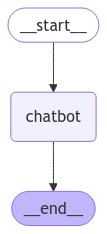

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: What is Langsmith?
Assistant: Langsmith is a surname of English origin. It is derived from the Old English words "lang," meaning long, and "smith," meaning a worker in metal. This surname likely originally referred to someone who was a blacksmith or metalworker known for their skill in working with metals.
User: No, I meant the langsmith framework from Langchain
Assistant: Apologies for the confusion. The Langsmith framework from Langchain is a technology that aims to provide a decentralized platform for multilingual content creation and translation. It leverages blockchain technology to facilitate secure and transparent transactions between content creators and translators. The framework also includes tools for managing translation projects, ensuring quality control, and rewarding contributors. Overall, Langsmith aims to revolutionize the language industry by providing a user-friendly and efficient platform for multilingual communication.
User: This is so wrong
Assistant: I'm so

# Build an agent with tools

In [5]:
%pip install -U tavily-python
%pip install -U langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.4 MB/s eta 0:00:00


In [6]:
os.environ["TAVILY_API_KEY"] = "your-api-key"  # Visit https://tavily.com/#api to get a key

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("Show me the latest research paper around chronic back pain?")

[{'url': 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9529058/',
  'content': "Evidence-based interventions to treat chronic low back pain: treatment selection for a personalized medicine approach\nMatthew C. Mauck\nDepartments ofaAnesthesiology\nAileen F. Aylward\nbEmergency Medicine, University of North Carolina at Chapel Hill, Chapel Hill, NC, USA\nChloe E. Barton\nDepartments ofaAnesthesiology\nBrandon Birckhead\ncDepartment of Psychiatry and Behavioral Sciences, Johns Hopkins School of Medicine, Baltimore, MD, USA\nTimothy Carey\ndDepartment of Medicine, University of North Carolina at Chapel Hill, Chapel Hill NC, USA\nDiane M. Dalton\neDepartment of Physical Therapy, Boston University, College of Health and Rehabilitation Sciences, Sargent, Boston MA, USA\nAaron J. Fields\nfDepartment of Orthopaedic Surgery, University of California San Francisco, San Francisco, CA, USA\nJulie Fritz\ngDepartment of Physical Therapy and Athletic Training, University of Utah, Salt Lake City, UT, U

In [19]:
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_tools = llm.bind_tools(tools) # Modification: tell the LLM which tools it can call


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

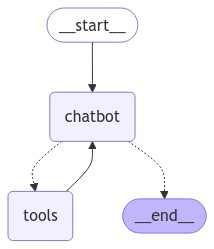

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: What is the latest news article published around chronic back pain?
Assistant: 
Assistant: [{"url": "https://www.sciencedaily.com/releases/2024/04/240430180330.htm", "content": "Sep. 29, 2021 — A study of chronic back pain patients finds that more than two-thirds of those who underwent a novel, 4-week psychological treatment were pain-free or nearly pain-free afterward ..."}, {"url": "https://medicalxpress.com/news/2024-09-placebos-alleviate-chronic-pain-patients.html", "content": "Honestly prescribed placebo treatments for chronic back pain (CPB) led to significant improvements in pain alleviation with lasting results, according to a new study out today in JAMA Network Open."}]
Assistant: Here are some of the latest news articles published around chronic back pain:

1. [Study Finds Psychological Treatment Helps Chronic Back Pain Patients](https://www.sciencedaily.com/releases/2024/04/240430180330.htm) - Published on Sep. 29, 2021. The study highlights that more than two-thirds o

# Build an agent with tools and memory

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver() #Stores the conversation in this session

In [13]:
graph = graph_builder.compile(checkpointer=memory)

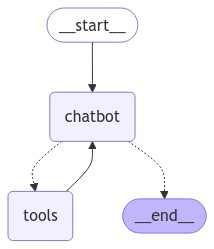

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
config = {"configurable": {"thread_id": "1"}} #Defines the session id between the user and the assistant

In [16]:
user_input = "Hi there! My name is Hernandez. I have been suffering from chronic back pain."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Hernandez. I have been suffering from chronic back pain.
================================== Ai Message ==================================

Hello Hernandez! I'm sorry to hear that you've been experiencing chronic back pain. Would you like me to look up some information or resources that could help you manage or alleviate your back pain?


In [17]:
user_input = "What are the latest state of the art techniques that can help me?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What are the latest state of the art techniques that can help me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_2E4hyoIPH7SGGqfBQJFFsonm)
 Call ID: call_2E4hyoIPH7SGGqfBQJFFsonm
  Args:
    query: latest state of the art techniques for chronic back pain
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.sciencedaily.com/releases/2022/08/220802121722.htm", "content": "The new treatment challenges traditional treatments for chronic back pain, such as drugs and treatments that focus on the back such as spinal manipulation, injections, surgery and spinal cord ..."}, {"url": "https://scitechdaily.com/at-last-an-effective-new-treatment-for-chronic-back-pain/", "content": "“This is the first new treatment of its kind for back pain – which has been

In [23]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='72d09684-47fa-4c22-9f24-3f82f322e53c'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 89, 'total_tokens': 100, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b5a32a2b-1b3c-4317-9857-a4c0f21d1ea8-0', usage_metadata={'input_tokens': 89, 'output_tokens': 11, 'total_tokens': 100}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='f0d31d09-dee0-477e-98c6-1a9bd1dc9ace'), AIMessage(content='Yes, I remember your name is Will. How can I help you today, Will?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 11